<a href="https://colab.research.google.com/github/bo-cheng-tsai/homework/blob/main/week7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed


Epoch [10/100], Loss: 0.0258
Epoch [20/100], Loss: 0.0212
Epoch [30/100], Loss: 0.0123
Epoch [40/100], Loss: 0.0073
Epoch [50/100], Loss: 0.0067
Epoch [60/100], Loss: 0.0064
Epoch [70/100], Loss: 0.0060
Epoch [80/100], Loss: 0.0056
Epoch [90/100], Loss: 0.0051
Epoch [100/100], Loss: 0.0048
Training RMSE: 38.67
Testing RMSE: 42.90


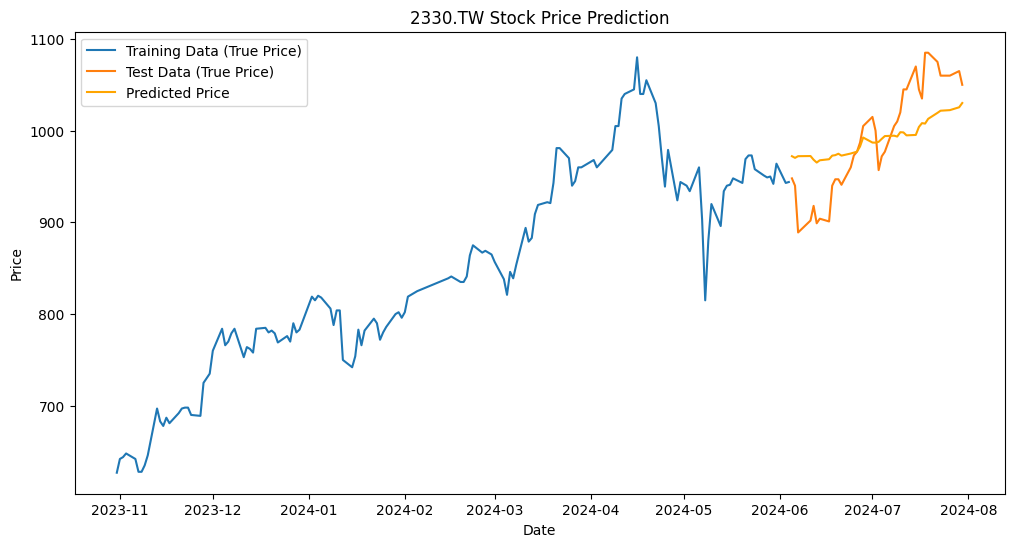

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.metrics import mean_squared_error
import math

# 載入股票資料
stock_id = "2330.TW"
end = dt.date.today()
start = end - dt.timedelta(days=365)  # 使用一年的資料
df = yf.download(stock_id, start=start, end=end)
df = df[['Close']]

# 正規化資料
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# 資料集製作
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(scaled_data, time_step)
X = torch.from_numpy(X).float().view(-1, time_step)
y = torch.from_numpy(y).float().view(-1, 1)

# 分割訓練與測試集
train_size = int(len(X) * 0.8)
train_X, test_X = X[:train_size], X[train_size:]
train_y, test_y = y[:train_size], y[train_size:]

# 定義模型
class StockPricePredictor(nn.Module):
    def __init__(self):
        super(StockPricePredictor, self).__init__()
        self.fc1 = nn.Linear(time_step, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = StockPricePredictor()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 訓練模型
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(train_X)
    loss = criterion(output, train_y)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# 預測
model.eval()
train_predict = model(train_X).detach().numpy()
test_predict = model(test_X).detach().numpy()

# 反正規化
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
train_y = scaler.inverse_transform(train_y.detach().numpy())
test_y = scaler.inverse_transform(test_y.detach().numpy())

# 計算 RMSE
train_rmse = math.sqrt(mean_squared_error(train_y, train_predict))
test_rmse = math.sqrt(mean_squared_error(test_y, test_predict))
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")

# 可視化
plt.figure(figsize=(12, 6))
plt.plot(df.index[:len(train_y)], train_y, label="Training Data (True Price)")
plt.plot(df.index[len(train_y):len(train_y) + len(test_y)], test_y, label="Test Data (True Price)")
plt.plot(df.index[len(train_y):len(train_y) + len(test_predict)], test_predict, label="Predicted Price", color='orange')
plt.xlabel("Date")
plt.ylabel("Price")
plt.title(f"{stock_id} Stock Price Prediction")
plt.legend()
plt.show()

In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# 載入股票資料
stock_id = "2330.TW"
end = dt.date.today()
start = end - dt.timedelta(days=365)
df = yf.download(stock_id, start=start, end=end)
df['5_SMA'] = df['Close'].rolling(window=5).mean()
df['10_SMA'] = df['Close'].rolling(window=10).mean()
df.dropna(inplace=True)

# 設定漲跌標籤
df['Label'] = np.where(df['5_SMA'] > df['10_SMA'], 1, 0)

# 特徵和標籤
X = df[['Open', 'High', 'Low', 'Close', 'Volume']].values
y = df['Label'].values

# 資料標準化
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 資料集劃分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 將資料轉換為 Tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# 資料載入
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32, shuffle=False)

# 定義改良的 CNN 模型
class ImprovedCNNModel(nn.Module):
    def __init__(self):
        super(ImprovedCNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=5, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.view(x.size(0), 5, -1)
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.squeeze(-1)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# 初始化模型、損失函數和優化器
model = ImprovedCNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# 訓練模型
epochs = 100
for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    scheduler.step()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

# 評估模型
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test data: {100 * correct / total:.2f}%')

[*********************100%***********************]  1 of 1 completed


Epoch 1/100, Loss: 0.6947
Epoch 2/100, Loss: 0.6551
Epoch 3/100, Loss: 0.6662
Epoch 4/100, Loss: 0.6100
Epoch 5/100, Loss: 0.6782
Epoch 6/100, Loss: 0.6082
Epoch 7/100, Loss: 0.6610
Epoch 8/100, Loss: 0.6831
Epoch 9/100, Loss: 0.7023
Epoch 10/100, Loss: 0.6181
Epoch 11/100, Loss: 0.4776
Epoch 12/100, Loss: 0.5356
Epoch 13/100, Loss: 0.4268
Epoch 14/100, Loss: 0.6106
Epoch 15/100, Loss: 0.5577
Epoch 16/100, Loss: 0.5882
Epoch 17/100, Loss: 0.7208
Epoch 18/100, Loss: 0.5776
Epoch 19/100, Loss: 0.6334
Epoch 20/100, Loss: 0.5994
Epoch 21/100, Loss: 0.6058
Epoch 22/100, Loss: 0.6229
Epoch 23/100, Loss: 0.6690
Epoch 24/100, Loss: 0.5441
Epoch 25/100, Loss: 0.6890
Epoch 26/100, Loss: 0.5564
Epoch 27/100, Loss: 0.5972
Epoch 28/100, Loss: 0.6116
Epoch 29/100, Loss: 0.5511
Epoch 30/100, Loss: 0.6702
Epoch 31/100, Loss: 0.6056
Epoch 32/100, Loss: 0.6008
Epoch 33/100, Loss: 0.6225
Epoch 34/100, Loss: 0.6241
Epoch 35/100, Loss: 0.6748
Epoch 36/100, Loss: 0.5796
Epoch 37/100, Loss: 0.6359
Epoch 38/1

In [68]:
import torch
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import StandardScaler

# 載入最新股票資料
stock_id = "2330.TW"
df_new = yf.download(stock_id, period="1y")  # 最新一年資料
df_new['5_SMA'] = df_new['Close'].rolling(window=5).mean()
df_new['10_SMA'] = df_new['Close'].rolling(window=10).mean()
df_new.dropna(inplace=True)

# 使用最近一筆資料進行預測
X_new = df_new[['Open', 'High', 'Low', 'Close', 'Volume']].values[-1].reshape(1, -1)
scaler = StandardScaler()
X_new = scaler.fit_transform(X_new)

# 將資料轉換為 Tensor 並輸入模型
X_new_tensor = torch.tensor(X_new, dtype=torch.float32).view(1, 5, -1)  # 確保形狀正確
model.eval()  # 設定模型為評估模式
with torch.no_grad():
    output = model(X_new_tensor)
    _, predicted = torch.max(output, 1)

# 將結果轉換為「漲」或「跌」
prediction = "漲" if predicted.item() == 1 else "跌"
print(f'預測結果: {prediction}')


[*********************100%***********************]  1 of 1 completed

預測結果: 漲
